## 매출은 업종별로 넣고 유동인구를 시간대로 나누지 않고 전체로 넣기 -ver1

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [3]:
# 한글 문제
# matplotlit의 기본 폰트에서 한글 지원되지 않기 때문에
# matplotlib의 폰트 변경 필요
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

In [43]:
columns = ['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명', '당월_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', 
           '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액', '여성_매출_금액',
          '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액']
sales = pd.read_csv('./data/서울시 상권분석서비스(추정매출-자치구).csv', encoding='cp949', usecols = columns, low_memory=False)
sales.head()

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,당월_매출_금액,시간대_00~06_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,시간대_21~24_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,연령대_50_매출_금액,연령대_60_이상_매출_금액
0,20191,종로구,화초,1495850124,0,222767026,361381719,348673696,541222248,21805435,465985416,614351753,4821242,236327182,286985195,225269811,249285099,77648643
1,20191,종로구,양식음식점,21733503173,413929513,123388190,6045931961,3643516680,8433242232,3073494597,8465129069,9530725644,136382198,6196833737,4967963671,3236855795,2407946855,1049872442
2,20191,종로구,치킨전문점,3247811505,382461305,74554617,182374892,148462018,1133940599,1326018074,1765155389,1134001754,40820693,927312845,698362320,599689873,471883377,161088031
3,20191,종로구,시계및귀금속,150561529485,0,4074265581,47523104816,60994758051,37787372266,182028771,69483673044,66687504758,181127570,13803201987,26143750620,26406134053,44761390011,24875573557
4,20191,종로구,일반의원,14993800118,0,2910962298,4490413329,4513260135,3047025979,32138377,6420163302,8529048076,69495695,1814359964,3318178411,3170413889,3463830467,3112932953


In [79]:
pop1 = pd.read_csv('./data/2023_1분기_구별유동인구.csv', encoding='cp949', low_memory=False)
pop1.head()

,자치구,방문자수
0,강남구,8052726
1,강동구,5535918
2,강북구,5864011
3,강서구,3724304
4,관악구,2179164


In [81]:
res = pop1.자치구.str.contains('강남구|서대문구|서초구|종로구', na=False)
pop_20231_4 = pop1[res]
pop_20231_4.head()

,자치구,방문자수
0,강남구,8052726
12,서대문구,398785
13,서초구,3359499
19,종로구,839452


In [85]:
pop2 = pd.read_csv('./data/2023_2분기_구별유동인구.csv', encoding='cp949', low_memory=False)
pop2.head()

,자치구,방문자수
0,강남구,6528508
1,강동구,2853697
2,강북구,2536070
3,강서구,1723046
4,관악구,2196907


In [86]:
res = pop2.자치구.str.contains('강남구|서대문구|서초구|종로구', na=False)
pop_20232_4 = pop2[res]
pop_20232_4.head()

,자치구,방문자수
0,강남구,6528508
12,서대문구,411871
13,서초구,3532895
19,종로구,1038603


In [44]:
# 23년도 1분기와 2분기 데이터 추출
sales_231 = sales[sales['기준_년분기_코드'] == 20231]
sales_232 = sales[sales['기준_년분기_코드'] == 20232]

In [5]:
# 23년도 1분기 2분기 매출 데이터프레임 정보확인
sales_231.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1543 entries, 7778 to 27713
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   기준_년분기_코드        1543 non-null   int64 
 1   자치구_코드_명         1543 non-null   object
 2   서비스_업종_코드_명      1543 non-null   object
 3   당월_매출_금액         1543 non-null   int64 
 4   시간대_00~06_매출_금액  1543 non-null   int64 
 5   시간대_06~11_매출_금액  1543 non-null   int64 
 6   시간대_11~14_매출_금액  1543 non-null   int64 
 7   시간대_14~17_매출_금액  1543 non-null   int64 
 8   시간대_17~21_매출_금액  1543 non-null   int64 
 9   시간대_21~24_매출_금액  1543 non-null   int64 
 10  남성_매출_금액         1543 non-null   int64 
 11  여성_매출_금액         1543 non-null   int64 
 12  연령대_10_매출_금액     1543 non-null   int64 
 13  연령대_20_매출_금액     1543 non-null   int64 
 14  연령대_30_매출_금액     1543 non-null   int64 
 15  연령대_40_매출_금액     1543 non-null   int64 
 16  연령대_50_매출_금액     1543 non-null   int64 
 17  연령대_60_이상_매출_금액  1543 non-null   i

In [36]:
sales_231.rename(columns = {'남성_매출_금액' : '1분기_남성_매출금액', '여성_매출_금액' : '1분기_여성_매출금액'}, inplace = True)

C:\Users\Gun Won Park\AppData\Local\Temp\ipykernel_21540\1510365446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_231.rename(columns = {'남성_매출_금액' : '1분기_남성_매출금액', '여성_매출_금액' : '1분기_여성_매출금액'}, inplace = True)


In [37]:
res = sales_231.자치구_코드_명.str.contains('강남구|서대문구|서초구|종로구', na=False)
sales_231_4 = sales_231[res]
sales_231_4.head()

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,당월_매출_금액,시간대_00~06_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,시간대_21~24_매출_금액,1분기_남성_매출금액,1분기_여성_매출금액,연령대_10_매출_금액,연령대_20_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,연령대_50_매출_금액,연령대_60_이상_매출_금액
7782,20231,종로구,호프-간이주점,26738282267,5018535634,169314944,740474004,915110731,6617933922,13276913032,15589784815,8272174677,231073191,6262373875,6908832639,4315115173,3863301723,2281262883
7790,20231,종로구,일반교습학원,3622643633,8697663,244045769,664835826,1160671616,1383932742,160460017,1523313771,2093077505,36452,103689367,237432765,1914740178,1258336967,102155547
7801,20231,강남구,인테리어,1755811670,0,337168319,528890451,734775363,154977537,0,738088896,591686536,0,53957143,179882969,220381752,412921473,462632092
7804,20231,종로구,핸드폰,2003692457,0,63667568,1166830989,605241304,165991019,1961577,1246412225,752682929,5176148,102942139,496139700,179584803,554793412,660458952
7811,20231,강남구,일식음식점,82172197418,3125883944,141817268,22522521847,5958065211,28414699381,22009209767,34838359275,24271286249,447116860,13707732914,21194548376,11433318822,7773362947,4553565601


In [38]:
age_231_10 = sales_231_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['연령대_10_매출_금액']
age_231_10.to_frame()

연령대_10_매출_금액
기준_년분기_코드 자치구_코드_명 서비스_업종_코드_명              
20231     강남구      PC방             694110467
                   가구                 295917
                   가방              241166885
                   가전제품              6225891
                   가전제품수리                  0
...                                      ...
          종로구      한의원               1281416
                   핸드폰               5176148
                   호프-간이주점         231073191
                   화장품             231170141
                   화초                9463071

[243 rows x 1 columns]

In [39]:
age_231_10 = age_231_10.reset_index()

In [30]:
age_231_10

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,연령대_10_매출_금액
0,20231,강남구,PC방,694110467
1,20231,강남구,가구,295917
2,20231,강남구,가방,241166885
3,20231,강남구,가전제품,6225891
4,20231,강남구,가전제품수리,0
...,...,...,...,...
238,20231,종로구,한의원,1281416
239,20231,종로구,핸드폰,5176148
240,20231,종로구,호프-간이주점,231073191
241,20231,종로구,화장품,231170141


In [40]:
age_231_10.rename(columns = {'연령대_10_매출_금액' : '매출금액'}, inplace = True)

In [22]:
age_231_10

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,매출금액
0,20231,강남구,PC방,694110467
1,20231,강남구,가구,295917
2,20231,강남구,가방,241166885
3,20231,강남구,가전제품,6225891
4,20231,강남구,가전제품수리,0
...,...,...,...,...
238,20231,종로구,한의원,1281416
239,20231,종로구,핸드폰,5176148
240,20231,종로구,호프-간이주점,231073191
241,20231,종로구,화장품,231170141


In [41]:
age_231_10['연령대'] = 10

In [43]:
age_231_10

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,매출금액,연령대
0,20231,강남구,PC방,694110467,10
1,20231,강남구,가구,295917,10
2,20231,강남구,가방,241166885,10
3,20231,강남구,가전제품,6225891,10
4,20231,강남구,가전제품수리,0,10
...,...,...,...,...,...
238,20231,종로구,한의원,1281416,10
239,20231,종로구,핸드폰,5176148,10
240,20231,종로구,호프-간이주점,231073191,10
241,20231,종로구,화장품,231170141,10


In [45]:
age_231_20 = sales_231_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['연령대_20_매출_금액']

In [46]:
age_231_20 = age_231_20.reset_index()

In [47]:
age_231_20.rename(columns = {'연령대_20_매출_금액' : '매출금액'}, inplace = True)

In [48]:
age_231_20['연령대'] = 20

In [49]:
age_231_20

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,매출금액,연령대
0,20231,강남구,PC방,3411953347,20
1,20231,강남구,가구,2810749820,20
2,20231,강남구,가방,2074208112,20
3,20231,강남구,가전제품,126395328,20
4,20231,강남구,가전제품수리,16021450,20
...,...,...,...,...,...
238,20231,종로구,한의원,268070661,20
239,20231,종로구,핸드폰,102942139,20
240,20231,종로구,호프-간이주점,6262373875,20
241,20231,종로구,화장품,6206414932,20


In [50]:
age_231_30 = sales_231_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['연령대_30_매출_금액']

In [51]:
age_231_30 = age_231_30.reset_index()

In [55]:
age_231_30.rename(columns = {'연령대_30_매출_금액' : '매출금액'}, inplace = True)

In [53]:
age_231_30['연령대'] = 30

In [56]:
age_231_30

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,매출금액,연령대
0,20231,강남구,PC방,1805092892,30
1,20231,강남구,가구,6135431329,30
2,20231,강남구,가방,2096347547,30
3,20231,강남구,가전제품,203600186,30
4,20231,강남구,가전제품수리,46147588,30
...,...,...,...,...,...
238,20231,종로구,한의원,833810660,30
239,20231,종로구,핸드폰,496139700,30
240,20231,종로구,호프-간이주점,6908832639,30
241,20231,종로구,화장품,4963979960,30


In [57]:
age_231_40 = sales_231_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['연령대_40_매출_금액']
age_231_40 = age_231_40.reset_index()
age_231_40.rename(columns = {'연령대_40_매출_금액' : '매출금액'}, inplace = True)
age_231_40['연령대'] = 40

In [58]:
age_231_40

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,매출금액,연령대
0,20231,강남구,PC방,659815720,40
1,20231,강남구,가구,7402126040,40
2,20231,강남구,가방,2505885034,40
3,20231,강남구,가전제품,316548721,40
4,20231,강남구,가전제품수리,53403176,40
...,...,...,...,...,...
238,20231,종로구,한의원,1229928138,40
239,20231,종로구,핸드폰,179584803,40
240,20231,종로구,호프-간이주점,4315115173,40
241,20231,종로구,화장품,2693387212,40


In [63]:
age_231_50 = sales_231_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['연령대_50_매출_금액']
age_231_50 = age_231_50.reset_index()
age_231_50.rename(columns = {'연령대_50_매출_금액' : '매출금액'}, inplace = True)
age_231_50['연령대'] = 50

In [64]:
age_231_50

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,매출금액,연령대
0,20231,강남구,PC방,855977475,50
1,20231,강남구,가구,12523864673,50
2,20231,강남구,가방,1990260872,50
3,20231,강남구,가전제품,144373617,50
4,20231,강남구,가전제품수리,67671947,50
...,...,...,...,...,...
238,20231,종로구,한의원,1484269608,50
239,20231,종로구,핸드폰,554793412,50
240,20231,종로구,호프-간이주점,3863301723,50
241,20231,종로구,화장품,3005090509,50


In [65]:
age_231_60 = sales_231_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['연령대_60_이상_매출_금액']
age_231_60 = age_231_60.reset_index()
age_231_60.rename(columns = {'연령대_60_이상_매출_금액' : '매출금액'}, inplace = True)
age_231_60['연령대'] = 60

In [66]:
age_231_60

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,매출금액,연령대
0,20231,강남구,PC방,184350273,60
1,20231,강남구,가구,14717642721,60
2,20231,강남구,가방,1144055225,60
3,20231,강남구,가전제품,145467926,60
4,20231,강남구,가전제품수리,110902616,60
...,...,...,...,...,...
238,20231,종로구,한의원,1632959470,60
239,20231,종로구,핸드폰,660458952,60
240,20231,종로구,호프-간이주점,2281262883,60
241,20231,종로구,화장품,1788087160,60


In [67]:
age_20231 = pd.concat([age_231_10, age_231_20, age_231_30, age_231_40, age_231_50, age_231_60], axis = 0)

In [68]:
age_20231

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,매출금액,연령대
0,20231,강남구,PC방,694110467,10
1,20231,강남구,가구,295917,10
2,20231,강남구,가방,241166885,10
3,20231,강남구,가전제품,6225891,10
4,20231,강남구,가전제품수리,0,10
...,...,...,...,...,...
238,20231,종로구,한의원,1632959470,60
239,20231,종로구,핸드폰,660458952,60
240,20231,종로구,호프-간이주점,2281262883,60
241,20231,종로구,화장품,1788087160,60


In [82]:
age_20231.rename(columns = {'자치구_코드_명' : '자치구'}, inplace = True)

In [83]:
data_20231 = pd.merge(age_20231, pop_20231_4, on = '자치구')

In [84]:
data_20231

,기준_년분기_코드,자치구,서비스_업종_코드_명,매출금액,연령대,방문자수
0,20231,강남구,PC방,694110467,10,8052726
1,20231,강남구,가구,295917,10,8052726
2,20231,강남구,가방,241166885,10,8052726
3,20231,강남구,가전제품,6225891,10,8052726
4,20231,강남구,가전제품수리,0,10,8052726
...,...,...,...,...,...,...
1453,20231,종로구,한의원,1632959470,60,839452
1454,20231,종로구,핸드폰,660458952,60,839452
1455,20231,종로구,호프-간이주점,2281262883,60,839452
1456,20231,종로구,화장품,1788087160,60,839452


In [87]:
res = sales_232.자치구_코드_명.str.contains('강남구|서대문구|서초구|종로구', na=False)
sales_232_4 = sales_232[res]
sales_232_4.head()

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,당월_매출_금액,시간대_00~06_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,시간대_21~24_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,연령대_50_매출_금액,연령대_60_이상_매출_금액
22862,20232,종로구,호프-간이주점,29247958594,5063388780,274825982,886192243,993414807,7724828289,14305308493,16246872214,9315819252,251808645,6773709648,7533447828,4369326812,4151870197,2482528303
22872,20232,서대문구,미곡판매,1110756057,0,256338693,286549439,327521617,240346308,0,547094918,558636121,0,11475983,138663076,74068457,302517988,579005535
22886,20232,종로구,중식음식점,15136352637,93367479,56323507,6228310099,1416926238,5879830798,1461594516,6605163448,3973945189,69897641,1767800672,2821582241,2375319615,1944644200,1599864271
22887,20232,종로구,가전제품,8101344900,0,1274162291,2324973489,3734548653,761838210,5822257,4297655232,2451234131,3842296,138664646,258079723,1321922230,1928080352,3098300112
22907,20232,서초구,의약품,105102778161,7542333,23773682923,42513606110,25342077743,13111025645,354843407,58576034682,45157756758,169020488,4569566104,21623600146,20400450868,24720280942,32250872892


In [90]:
age_232_10 = sales_232_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['연령대_10_매출_금액']
age_232_10 = age_232_10.reset_index()
age_232_10.rename(columns = {'연령대_10_매출_금액' : '매출금액'}, inplace = True)
age_232_10['연령대'] = 10

In [91]:
age_232_10

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,매출금액,연령대
0,20232,강남구,PC방,753754372,10
1,20232,강남구,가구,0,10
2,20232,강남구,가방,55795141,10
3,20232,강남구,가전제품,1079867,10
4,20232,강남구,가전제품수리,0,10
...,...,...,...,...,...
240,20232,종로구,한의원,6238478,10
241,20232,종로구,핸드폰,5786801,10
242,20232,종로구,호프-간이주점,251808645,10
243,20232,종로구,화장품,222362328,10


In [92]:
age_232_20 = sales_232_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['연령대_20_매출_금액']
age_232_20 = age_232_20.reset_index()
age_232_20.rename(columns = {'연령대_20_매출_금액' : '매출금액'}, inplace = True)
age_232_20['연령대'] = 20

In [93]:
age_232_30 = sales_232_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['연령대_30_매출_금액']
age_232_30 = age_232_30.reset_index()
age_232_30.rename(columns = {'연령대_30_매출_금액' : '매출금액'}, inplace = True)
age_232_30['연령대'] = 30

In [94]:
age_232_40 = sales_232_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['연령대_40_매출_금액']
age_232_40 = age_232_40.reset_index()
age_232_40.rename(columns = {'연령대_40_매출_금액' : '매출금액'}, inplace = True)
age_232_40['연령대'] = 40

In [95]:
age_232_50 = sales_232_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['연령대_50_매출_금액']
age_232_50 = age_232_50.reset_index()
age_232_50.rename(columns = {'연령대_50_매출_금액' : '매출금액'}, inplace = True)
age_232_50['연령대'] = 50

In [96]:
age_232_60 = sales_232_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['연령대_60_이상_매출_금액']
age_232_60 = age_232_60.reset_index()
age_232_60.rename(columns = {'연령대_60_이상_매출_금액' : '매출금액'}, inplace = True)
age_232_60['연령대'] = 60

In [97]:
age_232_60

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,매출금액,연령대
0,20232,강남구,PC방,133195646,60
1,20232,강남구,가구,13481409166,60
2,20232,강남구,가방,1883102525,60
3,20232,강남구,가전제품,425634174,60
4,20232,강남구,가전제품수리,101956408,60
...,...,...,...,...,...
240,20232,종로구,한의원,2056569711,60
241,20232,종로구,핸드폰,1284751468,60
242,20232,종로구,호프-간이주점,2482528303,60
243,20232,종로구,화장품,1628366860,60


In [98]:
age_20232 = pd.concat([age_232_10, age_232_20, age_232_30, age_232_40, age_232_50, age_232_60], axis = 0)

In [99]:
age_20232

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,매출금액,연령대
0,20232,강남구,PC방,753754372,10
1,20232,강남구,가구,0,10
2,20232,강남구,가방,55795141,10
3,20232,강남구,가전제품,1079867,10
4,20232,강남구,가전제품수리,0,10
...,...,...,...,...,...
240,20232,종로구,한의원,2056569711,60
241,20232,종로구,핸드폰,1284751468,60
242,20232,종로구,호프-간이주점,2482528303,60
243,20232,종로구,화장품,1628366860,60


In [100]:
age_20232.rename(columns = {'자치구_코드_명' : '자치구'}, inplace = True)

In [101]:
data_20232 = pd.merge(age_20232, pop_20232_4, on = '자치구')

In [102]:
data_20232

,기준_년분기_코드,자치구,서비스_업종_코드_명,매출금액,연령대,방문자수
0,20232,강남구,PC방,753754372,10,6528508
1,20232,강남구,가구,0,10,6528508
2,20232,강남구,가방,55795141,10,6528508
3,20232,강남구,가전제품,1079867,10,6528508
4,20232,강남구,가전제품수리,0,10,6528508
...,...,...,...,...,...,...
1465,20232,종로구,한의원,2056569711,60,1038603
1466,20232,종로구,핸드폰,1284751468,60,1038603
1467,20232,종로구,호프-간이주점,2482528303,60,1038603
1468,20232,종로구,화장품,1628366860,60,1038603


In [105]:
data_202312 = pd.concat([data_20231, data_20232], axis = 0, ignore_index = True)

In [106]:
data_202312

,기준_년분기_코드,자치구,서비스_업종_코드_명,매출금액,연령대,방문자수
0,20231,강남구,PC방,694110467,10,8052726
1,20231,강남구,가구,295917,10,8052726
2,20231,강남구,가방,241166885,10,8052726
3,20231,강남구,가전제품,6225891,10,8052726
4,20231,강남구,가전제품수리,0,10,8052726
...,...,...,...,...,...,...
2923,20232,종로구,한의원,2056569711,60,1038603
2924,20232,종로구,핸드폰,1284751468,60,1038603
2925,20232,종로구,호프-간이주점,2482528303,60,1038603
2926,20232,종로구,화장품,1628366860,60,1038603


In [107]:
data_202312.to_csv('./data/4개구_연령업종매출_유동인구_데이터.csv', encoding='cp949')

In [108]:
data_202312 = pd.read_csv('./data/4개구_연령업종매출_유동인구_데이터.csv', encoding='cp949', low_memory=False)

In [109]:
bigmkt = pd.read_csv('./data/4개구 대형점포수.csv', encoding='cp949', low_memory=False)
bigmkt.head()

,Unnamed: 0,지번주소,count
0,0,강남구,37
1,1,종로구,19
2,2,서대문구,17
3,3,서초구,11


In [110]:
bigmkt.rename(columns = {'지번주소' : '자치구'}, inplace = True)

In [111]:
bigmkt_2023 = pd.merge(data_202312, bigmkt, on = '자치구')

In [12]:
bigmkt_2023

,Unnamed: 0_x,기준_년분기_코드,자치구,서비스_업종_코드_명,매출금액,연령대,방문자수,Unnamed: 0_y,count
0,0,20231,강남구,PC방,694110467,10,8052726,0,37
1,1,20231,강남구,가구,295917,10,8052726,0,37
2,2,20231,강남구,가방,241166885,10,8052726,0,37
3,3,20231,강남구,가전제품,6225891,10,8052726,0,37
4,4,20231,강남구,가전제품수리,0,10,8052726,0,37
...,...,...,...,...,...,...,...,...,...
2923,2923,20232,종로구,한의원,2056569711,60,1038603,1,19
2924,2924,20232,종로구,핸드폰,1284751468,60,1038603,1,19
2925,2925,20232,종로구,호프-간이주점,2482528303,60,1038603,1,19
2926,2926,20232,종로구,화장품,1628366860,60,1038603,1,19


In [112]:
bigmkt_2023.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis = 1, inplace = True)

In [113]:
bigmkt_2023.rename(columns = {'count' : '대형점포'}, inplace = True)

In [15]:
bigmkt_2023

,기준_년분기_코드,자치구,서비스_업종_코드_명,매출금액,연령대,방문자수,대형점포
0,20231,강남구,PC방,694110467,10,8052726,37
1,20231,강남구,가구,295917,10,8052726,37
2,20231,강남구,가방,241166885,10,8052726,37
3,20231,강남구,가전제품,6225891,10,8052726,37
4,20231,강남구,가전제품수리,0,10,8052726,37
...,...,...,...,...,...,...,...
2923,20232,종로구,한의원,2056569711,60,1038603,19
2924,20232,종로구,핸드폰,1284751468,60,1038603,19
2925,20232,종로구,호프-간이주점,2482528303,60,1038603,19
2926,20232,종로구,화장품,1628366860,60,1038603,19


In [114]:
hospital = pd.read_csv('./data/구별_병원수.csv', low_memory=False)
hospital.head()

,Unnamed: 0,자치구,병원수
0,0,강남구,3197
1,1,서초구,1543
2,2,송파구,1356
3,3,강서구,987
4,4,강동구,942


In [115]:
res = hospital.자치구.str.contains('강남구|서대문구|서초구|종로구', na=False)
hospital_4 = hospital[res]
hospital_4.head()

,Unnamed: 0,자치구,병원수
0,0,강남구,3197
1,1,서초구,1543
18,18,종로구,538
21,21,서대문구,474


In [116]:
hospital_2023 = pd.merge(bigmkt_2023, hospital_4, on = '자치구')

In [21]:
hospital_2023

,기준_년분기_코드,자치구,서비스_업종_코드_명,매출금액,연령대,방문자수,대형점포,Unnamed: 0,병원수
0,20231,강남구,PC방,694110467,10,8052726,37,0,3197
1,20231,강남구,가구,295917,10,8052726,37,0,3197
2,20231,강남구,가방,241166885,10,8052726,37,0,3197
3,20231,강남구,가전제품,6225891,10,8052726,37,0,3197
4,20231,강남구,가전제품수리,0,10,8052726,37,0,3197
...,...,...,...,...,...,...,...,...,...
2923,20232,종로구,한의원,2056569711,60,1038603,19,18,538
2924,20232,종로구,핸드폰,1284751468,60,1038603,19,18,538
2925,20232,종로구,호프-간이주점,2482528303,60,1038603,19,18,538
2926,20232,종로구,화장품,1628366860,60,1038603,19,18,538


In [117]:
hospital_2023.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [24]:
hospital_2023

,기준_년분기_코드,자치구,서비스_업종_코드_명,매출금액,연령대,방문자수,대형점포,병원수
0,20231,강남구,PC방,694110467,10,8052726,37,3197
1,20231,강남구,가구,295917,10,8052726,37,3197
2,20231,강남구,가방,241166885,10,8052726,37,3197
3,20231,강남구,가전제품,6225891,10,8052726,37,3197
4,20231,강남구,가전제품수리,0,10,8052726,37,3197
...,...,...,...,...,...,...,...,...
2923,20232,종로구,한의원,2056569711,60,1038603,19,538
2924,20232,종로구,핸드폰,1284751468,60,1038603,19,538
2925,20232,종로구,호프-간이주점,2482528303,60,1038603,19,538
2926,20232,종로구,화장품,1628366860,60,1038603,19,538


In [118]:
# '서비스_업종_코드_명'와 '연령대' 열에 대해 원핫 인코딩 적용
service_one_hot = pd.get_dummies(hospital_2023[['서비스_업종_코드_명', '연령대', '자치구']], columns=['서비스_업종_코드_명', '연령대', '자치구'], prefix=['service', 'age', 'gu'])

# 기존 데이터프레임과 합치기
hospital_2023 = pd.concat([hospital_2023.drop(['서비스_업종_코드_명', '연령대', '자치구'], axis=1), service_one_hot], axis=1)

In [84]:
hospital_2023.head()

,기준_년분기_코드,매출금액,방문자수,대형점포,병원수,service_PC방,service_가구,service_가방,service_가전제품,service_가전제품수리,...,age_10,age_20,age_30,age_40,age_50,age_60,gu_강남구,gu_서대문구,gu_서초구,gu_종로구
0,20231,694110467,8052726,37,3197,True,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
1,20231,295917,8052726,37,3197,False,True,False,False,False,...,True,False,False,False,False,False,True,False,False,False
2,20231,241166885,8052726,37,3197,False,False,True,False,False,...,True,False,False,False,False,False,True,False,False,False
3,20231,6225891,8052726,37,3197,False,False,False,True,False,...,True,False,False,False,False,False,True,False,False,False
4,20231,0,8052726,37,3197,False,False,False,False,True,...,True,False,False,False,False,False,True,False,False,False


In [122]:
hospital_2023.describe()

,기준_년분기_코드,매출금액,방문자수,대형점포,병원수
count,2928.000000,2.928000e+03,2.928000e+03,2928.000000,2928.000000
mean,20231.502049,3.955642e+09,3.074897e+06,21.155738,1460.057377
std,0.500081,1.062324e+10,2.766697e+06,9.799231,1108.723077
min,20231.000000,0.000000e+00,3.987850e+05,11.000000,474.000000
25%,20231.000000,1.007785e+08,8.394520e+05,15.500000,538.000000
50%,20232.000000,6.377068e+08,3.359499e+06,19.000000,1543.000000
75%,20232.000000,2.990851e+09,6.528508e+06,37.000000,3197.000000
max,20232.000000,1.119605e+11,8.052726e+06,37.000000,3197.000000


In [119]:
# 타깃과 피처
y_target = hospital_2023['매출금액']
X_features = hospital_2023.drop(['매출금액'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)

In [120]:
# 일반 선형 회귀
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
# 릿찌회귀
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
# 라쏘 회귀
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

C:\Users\Gun Won Park\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.79835e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Gun Won Park\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.514e+22, tolerance: 2.331e+19
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [121]:
get_rmses([lr_reg, ridge_reg, lasso_reg])

LinearRegression 로그 변환된 RMSE: 9483221606.195
Ridge 로그 변환된 RMSE: 9512552144.438
Lasso 로그 변환된 RMSE: 9483477328.729


[9483221606.195042, 9512552144.43838, 9483477328.729023]

In [123]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 2342 entries, 2259 to 860
Series name: 매출금액
Non-Null Count  Dtype
--------------  -----
2342 non-null   int64
dtypes: int64(1)
memory usage: 36.6 KB


In [86]:
# SalePrice 로그 변환
original_SalePrice = hospital_2023['매출금액'] #원래값 저장
hospital_2023['매출금액']=np.log1p(hospital_2023['매출금액']) #로그변환 값으로 타겟값을 대체

In [87]:
# 단일 모델의 RMSE 값 반환
def get_rmse(model): # 학습된 모델을 받아서 예측
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 여러 모델의 RMSE 값 반환
def get_rmses(models) :
    rmses = [] #반환 된 각 모델의 rmse값 저장
    for model in models :
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses # 전달된 모델들의 rmse 값들이 저장된 list가 반환

In [96]:
#학습된 모델 전달하고
models = [lr_reg, ridge_reg, lasso_reg]
# rmse값 반환
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 2.766
Ridge 로그 변환된 RMSE: 2.755
Lasso 로그 변환된 RMSE: 4.206


[2.7657059669761037, 2.754604104539526, 4.20612767766691]

In [93]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2342 entries, 2259 to 860
Data columns (total 77 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   기준_년분기_코드             2342 non-null   int64
 1   방문자수                  2342 non-null   int64
 2   대형점포                  2342 non-null   int64
 3   병원수                   2342 non-null   int64
 4   service_PC방           2342 non-null   bool 
 5   service_가구            2342 non-null   bool 
 6   service_가방            2342 non-null   bool 
 7   service_가전제품          2342 non-null   bool 
 8   service_가전제품수리        2342 non-null   bool 
 9   service_고시원           2342 non-null   bool 
 10  service_골프연습장         2342 non-null   bool 
 11  service_네일숍           2342 non-null   bool 
 12  service_노래방           2342 non-null   bool 
 13  service_당구장           2342 non-null   bool 
 14  service_문구            2342 non-null   bool 
 15  service_미곡판매          2342 non-null   bool 
 16  service_미

TypeError: Image data of dtype object cannot be converted to float

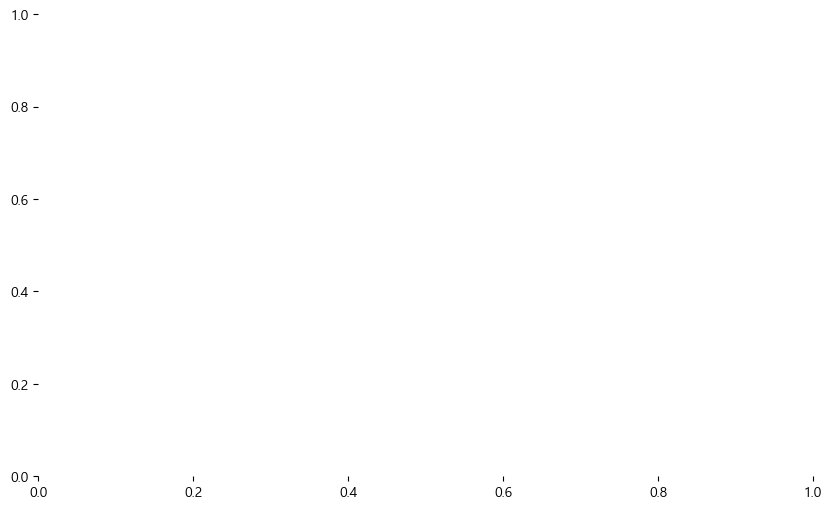

In [85]:
plt.figure(figsize=(10,6))
sns.heatmap(hospital_2023, annot = True, fmt = 'd')
plt.title('heatmap')
plt.show()

In [30]:
data_fin = school[['자치구', '학교수']]

In [31]:
data_fin

,자치구,학교수
0,강남구,209
1,강남구,209
2,서대문구,69
3,서대문구,69
4,서초구,136
5,서초구,136
6,종로구,218
7,종로구,218


In [38]:
data_fin.drop_duplicates(inplace = True)

C:\Users\Gun Won Park\AppData\Local\Temp\ipykernel_8068\847200359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fin.drop_duplicates(inplace = True)


In [39]:
data_fin

,자치구,학교수
0,강남구,209
2,서대문구,69
4,서초구,136
6,종로구,218


In [40]:
school_2023 = pd.merge(hospital_2023, data_fin, on = '자치구')

In [41]:
school_2023

,기준_년분기_코드,자치구,서비스_업종_코드_명,매출금액,연령대,방문자수,대형점포,병원수,학교수
0,20231,강남구,PC방,694110467,10,8052726,37,3197,209
1,20231,강남구,가구,295917,10,8052726,37,3197,209
2,20231,강남구,가방,241166885,10,8052726,37,3197,209
3,20231,강남구,가전제품,6225891,10,8052726,37,3197,209
4,20231,강남구,가전제품수리,0,10,8052726,37,3197,209
...,...,...,...,...,...,...,...,...,...
2923,20232,종로구,한의원,2056569711,60,1038603,19,538,218
2924,20232,종로구,핸드폰,1284751468,60,1038603,19,538,218
2925,20232,종로구,호프-간이주점,2482528303,60,1038603,19,538,218
2926,20232,종로구,화장품,1628366860,60,1038603,19,538,218


In [42]:
school_2023.to_csv('./data/4개구_연령업종매출_유동인구_기반시설_데이터.csv', encoding='cp949')

In [11]:
res2 = sales_232.자치구_코드_명.str.contains('강남구|서대문구|서초구|종로구', na=False)
sales_232_4 = sales_232[res2]
sales_232_4.head()

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,당월_매출_금액,시간대_00~06_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,시간대_21~24_매출_금액,2분기_남성_매출금액,2분기_여성_매출금액,연령대_10_매출_금액,연령대_20_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,연령대_50_매출_금액,연령대_60_이상_매출_금액
22862,20232,종로구,호프-간이주점,29247958594,5063388780,274825982,886192243,993414807,7724828289,14305308493,16246872214,9315819252,251808645,6773709648,7533447828,4369326812,4151870197,2482528303
22872,20232,서대문구,미곡판매,1110756057,0,256338693,286549439,327521617,240346308,0,547094918,558636121,0,11475983,138663076,74068457,302517988,579005535
22886,20232,종로구,중식음식점,15136352637,93367479,56323507,6228310099,1416926238,5879830798,1461594516,6605163448,3973945189,69897641,1767800672,2821582241,2375319615,1944644200,1599864271
22887,20232,종로구,가전제품,8101344900,0,1274162291,2324973489,3734548653,761838210,5822257,4297655232,2451234131,3842296,138664646,258079723,1321922230,1928080352,3098300112
22907,20232,서초구,의약품,105102778161,7542333,23773682923,42513606110,25342077743,13111025645,354843407,58576034682,45157756758,169020488,4569566104,21623600146,20400450868,24720280942,32250872892


In [12]:
gender_232 = sales_232_4.groupby(['자치구_코드_명']).sum()[['2분기_남성_매출금액', '2분기_여성_매출금액']]
gender_232

,2분기_남성_매출금액,2분기_여성_매출금액
자치구_코드_명,,
강남구,1407452769822,1560971511724
서대문구,227454452097,253195727832
서초구,683065417973,702485000254
종로구,534492002664,468155338351


In [13]:
gen_sales = pd.merge(gender_231, gender_232, on = '자치구_코드_명')
gen_sales

,1분기_남성_매출금액,1분기_여성_매출금액,2분기_남성_매출금액,2분기_여성_매출금액
자치구_코드_명,,,,
강남구,1442164470810,1565427553436,1407452769822,1560971511724
서대문구,214851293129,221418779181,227454452097,253195727832
서초구,676892455945,667980189679,683065417973,702485000254
종로구,511508998838,444600869734,534492002664,468155338351


In [47]:
gender_20231 = gender_231[gender_231['기준_년분기_코드'] == 20231][['1분기_남성_매출금액', '1분기_여성_매출금액']].sum()
gender_20231

1분기_남성_매출금액    12189011322165
1분기_여성_매출금액    11277256326274
dtype: int64

In [48]:
gender_20231.to_frame()

,0
1분기_남성_매출금액,12189011322165
1분기_여성_매출금액,11277256326274


In [49]:
gender_20231 = gender_20231.reset_index()

In [50]:
gender_20231

,index,0
0,1분기_남성_매출금액,12189011322165
1,1분기_여성_매출금액,11277256326274


In [51]:
gender_20231.rename(columns = {'index' : '성별_매출금액', 0 : '매출액'}, inplace = True)

In [52]:
gender_20231

,성별_매출금액,매출액
0,1분기_남성_매출금액,12189011322165
1,1분기_여성_매출금액,11277256326274


In [6]:
sales_232.rename(columns = {'남성_매출_금액' : '2분기_남성_매출금액', '여성_매출_금액' : '2분기_여성_매출금액'}, inplace = True)

C:\Users\Gun Won Park\AppData\Local\Temp\ipykernel_12108\2740666723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_232.rename(columns = {'남성_매출_금액' : '2분기_남성_매출금액', '여성_매출_금액' : '2분기_여성_매출금액'}, inplace = True)


In [55]:
gender_20232 = sales_232[sales_232['기준_년분기_코드'] == 20232][['2분기_남성_매출금액', '2분기_여성_매출금액']].sum()
gender_20232

2분기_남성_매출금액    12413554371939
2분기_여성_매출금액    11762992895279
dtype: int64

In [56]:
gender_20232.to_frame()

,0
2분기_남성_매출금액,12413554371939
2분기_여성_매출금액,11762992895279


In [57]:
gender_20232 = gender_20232.reset_index()

In [58]:
gender_20232.rename(columns = {'index' : '성별_매출금액', 0 : '매출액'}, inplace = True)

In [59]:
gender_20232

,성별_매출금액,매출액
0,2분기_남성_매출금액,12413554371939
1,2분기_여성_매출금액,11762992895279


In [60]:
gender_sales = pd.concat([gender_20231, gender_20232], axis = 0)

In [62]:
gender_sales = gender_sales.reset_index()

In [65]:
gender_sales = gender_sales.drop('index', axis = 1)

In [66]:
gender_sales

,성별_매출금액,매출액
0,1분기_남성_매출금액,12189011322165
1,1분기_여성_매출금액,11277256326274
2,2분기_남성_매출금액,12413554371939
3,2분기_여성_매출금액,11762992895279


## 매출은 업종별로 넣고 유동인구를 시간대로 나누지 않고 전체로 넣기 -ver2

In [14]:
sales_231.rename(columns = {'당월_매출_금액' : '1분기_매출금액'}, inplace = True)

C:\Users\Gun Won Park\AppData\Local\Temp\ipykernel_12108\2992636188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_231.rename(columns = {'당월_매출_금액' : '1분기_매출금액'}, inplace = True)


In [15]:
res = sales_231.자치구_코드_명.str.contains('강남구|서대문구|서초구|종로구', na=False)
sales_231_4 = sales_231[res]
sales_231_4.head()

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,1분기_매출금액,시간대_00~06_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,시간대_21~24_매출_금액,1분기_남성_매출금액,1분기_여성_매출금액,연령대_10_매출_금액,연령대_20_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,연령대_50_매출_금액,연령대_60_이상_매출_금액
7782,20231,종로구,호프-간이주점,26738282267,5018535634,169314944,740474004,915110731,6617933922,13276913032,15589784815,8272174677,231073191,6262373875,6908832639,4315115173,3863301723,2281262883
7790,20231,종로구,일반교습학원,3622643633,8697663,244045769,664835826,1160671616,1383932742,160460017,1523313771,2093077505,36452,103689367,237432765,1914740178,1258336967,102155547
7801,20231,강남구,인테리어,1755811670,0,337168319,528890451,734775363,154977537,0,738088896,591686536,0,53957143,179882969,220381752,412921473,462632092
7804,20231,종로구,핸드폰,2003692457,0,63667568,1166830989,605241304,165991019,1961577,1246412225,752682929,5176148,102942139,496139700,179584803,554793412,660458952
7811,20231,강남구,일식음식점,82172197418,3125883944,141817268,22522521847,5958065211,28414699381,22009209767,34838359275,24271286249,447116860,13707732914,21194548376,11433318822,7773362947,4553565601


In [31]:
item_231 = sales_231_4.groupby(['자치구_코드_명', '서비스_업종_코드_명']).sum()[['1분기_매출금액']]

In [32]:
item_231.head()

1분기_매출금액
자치구_코드_명 서비스_업종_코드_명             
강남구      PC방           7643503674
         가구           48769586179
         가방           10216206514
         가전제품          1193766974
         가전제품수리         323710998

In [18]:
item_231 = item_231.reset_index()

In [19]:
item_231.head()

,자치구_코드_명,서비스_업종_코드_명,1분기_매출금액
0,강남구,PC방,7643503674
1,강남구,가구,48769586179
2,강남구,가방,10216206514
3,강남구,가전제품,1193766974
4,강남구,가전제품수리,323710998


In [20]:
sales_232.rename(columns = {'당월_매출_금액' : '2분기_매출금액'}, inplace = True)

C:\Users\Gun Won Park\AppData\Local\Temp\ipykernel_12108\2853712846.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_232.rename(columns = {'당월_매출_금액' : '2분기_매출금액'}, inplace = True)


In [21]:
res2 = sales_232.자치구_코드_명.str.contains('강남구|서대문구|서초구|종로구', na=False)
sales_232_4 = sales_232[res2]
sales_232_4.head()

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,2분기_매출금액,시간대_00~06_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,시간대_21~24_매출_금액,2분기_남성_매출금액,2분기_여성_매출금액,연령대_10_매출_금액,연령대_20_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,연령대_50_매출_금액,연령대_60_이상_매출_금액
22862,20232,종로구,호프-간이주점,29247958594,5063388780,274825982,886192243,993414807,7724828289,14305308493,16246872214,9315819252,251808645,6773709648,7533447828,4369326812,4151870197,2482528303
22872,20232,서대문구,미곡판매,1110756057,0,256338693,286549439,327521617,240346308,0,547094918,558636121,0,11475983,138663076,74068457,302517988,579005535
22886,20232,종로구,중식음식점,15136352637,93367479,56323507,6228310099,1416926238,5879830798,1461594516,6605163448,3973945189,69897641,1767800672,2821582241,2375319615,1944644200,1599864271
22887,20232,종로구,가전제품,8101344900,0,1274162291,2324973489,3734548653,761838210,5822257,4297655232,2451234131,3842296,138664646,258079723,1321922230,1928080352,3098300112
22907,20232,서초구,의약품,105102778161,7542333,23773682923,42513606110,25342077743,13111025645,354843407,58576034682,45157756758,169020488,4569566104,21623600146,20400450868,24720280942,32250872892


In [29]:
item_232 = sales_232_4.groupby(['자치구_코드_명', '서비스_업종_코드_명']).sum()[['2분기_매출금액']]

In [30]:
item_232

2분기_매출금액
자치구_코드_명 서비스_업종_코드_명             
강남구      PC방           7247372105
         가구           57066773982
         가방           11767756928
         가전제품          1559649668
         가전제품수리         278461007

In [24]:
item_232 = item_232.reset_index()

In [25]:
item_232.head()

,자치구_코드_명,서비스_업종_코드_명,2분기_매출금액
0,강남구,PC방,7247372105
1,강남구,가구,57066773982
2,강남구,가방,11767756928
3,강남구,가전제품,1559649668
4,강남구,가전제품수리,278461007


In [112]:
item_232.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   자치구_코드_명     245 non-null    object
 1   서비스_업종_코드_명  245 non-null    object
 2   2분기_매출금액     245 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.9+ KB


In [33]:
itm_sales = pd.merge(item_231, item_232, on=['자치구_코드_명', '서비스_업종_코드_명'])
itm_sales

1분기_매출금액     2분기_매출금액
자치구_코드_명 서비스_업종_코드_명                          
강남구      PC방           7643503674   7247372105
         가구           48769586179  57066773982
         가방           10216206514  11767756928
         가전제품          1193766974   1559649668
         가전제품수리         323710998    278461007
...                           ...          ...
종로구      한의원           5535206112   5857547888
         핸드폰           2003692457   2614523114
         호프-간이주점      26738282267  29247958594
         화장품          19433903798  16897796490
         화초            2319167614   2432427498

[243 rows x 2 columns]

In [38]:
itm_sales.to_csv('./data/4개구 업종별 분기 매출액.csv', encoding='cp949')

In [39]:
itm_sales = pd.read_csv('./data/4개구 업종별 분기 매출액.csv', encoding='cp949', low_memory=False)

In [40]:
itm_sales

,자치구_코드_명,서비스_업종_코드_명,1분기_매출금액,2분기_매출금액
0,강남구,PC방,7643503674,7247372105
1,강남구,가구,48769586179,57066773982
2,강남구,가방,10216206514,11767756928
3,강남구,가전제품,1193766974,1559649668
4,강남구,가전제품수리,323710998,278461007
...,...,...,...,...
238,종로구,한의원,5535206112,5857547888
239,종로구,핸드폰,2003692457,2614523114
240,종로구,호프-간이주점,26738282267,29247958594
241,종로구,화장품,19433903798,16897796490


In [41]:
itm_gen = pd.merge(itm_sales, gen_sales, on = '자치구_코드_명').groupby('서비스_업종_코드_명')

In [43]:
itm_gen.head()

,자치구_코드_명,서비스_업종_코드_명,1분기_매출금액,2분기_매출금액,1분기_남성_매출금액,1분기_여성_매출금액,2분기_남성_매출금액,2분기_여성_매출금액
0,강남구,PC방,7643503674,7247372105,1442164470810,1565427553436,1407452769822,1560971511724
1,강남구,가구,48769586179,57066773982,1442164470810,1565427553436,1407452769822,1560971511724
2,강남구,가방,10216206514,11767756928,1442164470810,1565427553436,1407452769822,1560971511724
3,강남구,가전제품,1193766974,1559649668,1442164470810,1565427553436,1407452769822,1560971511724
4,강남구,가전제품수리,323710998,278461007,1442164470810,1565427553436,1407452769822,1560971511724
...,...,...,...,...,...,...,...,...
238,종로구,한의원,5535206112,5857547888,511508998838,444600869734,534492002664,468155338351
239,종로구,핸드폰,2003692457,2614523114,511508998838,444600869734,534492002664,468155338351
240,종로구,호프-간이주점,26738282267,29247958594,511508998838,444600869734,534492002664,468155338351
241,종로구,화장품,19433903798,16897796490,511508998838,444600869734,534492002664,468155338351


In [29]:
school = pd.read_csv('./data/total_1.csv', low_memory=False)
school.head()

,Unnamed: 0,자치구,분기,00-06시,06-11시,11-14시,14-17시,17-21시,21-23시,학교수,당월_매출_금액
0,0,강남구,20231,1411138,2450566,2396572,2510847,3467037,1568085,209,3415287707203
1,1,강남구,20232,1411138,2450566,2396572,2510847,3467037,1568085,209,3379709345136
2,2,서대문구,20231,24807,159445,169793,186175,183827,43828,69,463356727710
3,3,서대문구,20232,24807,159445,169793,186175,183827,43828,69,509806831106
4,4,서초구,20231,211367,1090472,1196537,1293022,2068352,737694,136,1549062993299


## 업종별 시간대 매출 대비 방문자 수를 넣기 -ver1

In [45]:
sales_231.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1543 entries, 7778 to 27713
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   기준_년분기_코드        1543 non-null   int64 
 1   자치구_코드_명         1543 non-null   object
 2   서비스_업종_코드_명      1543 non-null   object
 3   당월_매출_금액         1543 non-null   int64 
 4   시간대_00~06_매출_금액  1543 non-null   int64 
 5   시간대_06~11_매출_금액  1543 non-null   int64 
 6   시간대_11~14_매출_금액  1543 non-null   int64 
 7   시간대_14~17_매출_금액  1543 non-null   int64 
 8   시간대_17~21_매출_금액  1543 non-null   int64 
 9   시간대_21~24_매출_금액  1543 non-null   int64 
 10  남성_매출_금액         1543 non-null   int64 
 11  여성_매출_금액         1543 non-null   int64 
 12  연령대_10_매출_금액     1543 non-null   int64 
 13  연령대_20_매출_금액     1543 non-null   int64 
 14  연령대_30_매출_금액     1543 non-null   int64 
 15  연령대_40_매출_금액     1543 non-null   int64 
 16  연령대_50_매출_금액     1543 non-null   int64 
 17  연령대_60_이상_매출_금액  1543 non-null   i

In [46]:
res = sales_231.자치구_코드_명.str.contains('강남구|서대문구|서초구|종로구', na=False)
sales_231_4 = sales_231[res]
sales_231_4.head()

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,당월_매출_금액,시간대_00~06_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,시간대_21~24_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,연령대_50_매출_금액,연령대_60_이상_매출_금액
7782,20231,종로구,호프-간이주점,26738282267,5018535634,169314944,740474004,915110731,6617933922,13276913032,15589784815,8272174677,231073191,6262373875,6908832639,4315115173,3863301723,2281262883
7790,20231,종로구,일반교습학원,3622643633,8697663,244045769,664835826,1160671616,1383932742,160460017,1523313771,2093077505,36452,103689367,237432765,1914740178,1258336967,102155547
7801,20231,강남구,인테리어,1755811670,0,337168319,528890451,734775363,154977537,0,738088896,591686536,0,53957143,179882969,220381752,412921473,462632092
7804,20231,종로구,핸드폰,2003692457,0,63667568,1166830989,605241304,165991019,1961577,1246412225,752682929,5176148,102942139,496139700,179584803,554793412,660458952
7811,20231,강남구,일식음식점,82172197418,3125883944,141817268,22522521847,5958065211,28414699381,22009209767,34838359275,24271286249,447116860,13707732914,21194548376,11433318822,7773362947,4553565601


In [53]:
time_231_06 = sales_231_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['시간대_00~06_매출_금액']
time_231_06.to_frame()

시간대_00~06_매출_금액
기준_년분기_코드 자치구_코드_명 서비스_업종_코드_명                 
20231     강남구      PC방               1188775231
                   가구                         0
                   가방                         0
                   가전제품                       0
                   가전제품수리                     0
...                                         ...
          종로구      한의원                        0
                   핸드폰                        0
                   호프-간이주점           5018535634
                   화장품                   432941
                   화초                   2906546

[243 rows x 1 columns]

In [54]:
time_231_06 = time_231_06.reset_index()

In [55]:
time_231_06

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,시간대_00~06_매출_금액
0,20231,강남구,PC방,1188775231
1,20231,강남구,가구,0
2,20231,강남구,가방,0
3,20231,강남구,가전제품,0
4,20231,강남구,가전제품수리,0
...,...,...,...,...
238,20231,종로구,한의원,0
239,20231,종로구,핸드폰,0
240,20231,종로구,호프-간이주점,5018535634
241,20231,종로구,화장품,432941


In [60]:
time_231_611 = sales_231_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['시간대_06~11_매출_금액']
time_231_611.to_frame()

시간대_06~11_매출_금액
기준_년분기_코드 자치구_코드_명 서비스_업종_코드_명                 
20231     강남구      PC방                479148287
                   가구                3761060498
                   가방                 131394175
                   가전제품                12511942
                   가전제품수리              56245379
...                                         ...
          종로구      한의원                687632984
                   핸드폰                 63667568
                   호프-간이주점            169314944
                   화장품                696534952
                   화초                 293608643

[243 rows x 1 columns]

In [61]:
time_231_611 = time_231_611.reset_index()
time_231_611

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,시간대_06~11_매출_금액
0,20231,강남구,PC방,479148287
1,20231,강남구,가구,3761060498
2,20231,강남구,가방,131394175
3,20231,강남구,가전제품,12511942
4,20231,강남구,가전제품수리,56245379
...,...,...,...,...
238,20231,종로구,한의원,687632984
239,20231,종로구,핸드폰,63667568
240,20231,종로구,호프-간이주점,169314944
241,20231,종로구,화장품,696534952


In [59]:
time_231_1114 = sales_231_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['시간대_11~14_매출_금액']
time_231_1114.to_frame()
time_231_1114 = time_231_1114.reset_index()
time_231_1114

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,시간대_11~14_매출_금액
0,20231,강남구,PC방,955305171
1,20231,강남구,가구,12423394052
2,20231,강남구,가방,2573892338
3,20231,강남구,가전제품,336772574
4,20231,강남구,가전제품수리,99448259
...,...,...,...,...
238,20231,종로구,한의원,2142942874
239,20231,종로구,핸드폰,1166830989
240,20231,종로구,호프-간이주점,740474004
241,20231,종로구,화장품,4192346250


In [62]:
time_231_1417 = sales_231_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['시간대_14~17_매출_금액']
time_231_1417.to_frame()
time_231_1417 = time_231_1417.reset_index()
time_231_1417

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,시간대_14~17_매출_금액
0,20231,강남구,PC방,1314266919
1,20231,강남구,가구,20973602584
2,20231,강남구,가방,3615734256
3,20231,강남구,가전제품,472235445
4,20231,강남구,가전제품수리,128281126
...,...,...,...,...
238,20231,종로구,한의원,1758748617
239,20231,종로구,핸드폰,605241304
240,20231,종로구,호프-간이주점,915110731
241,20231,종로구,화장품,5243934104


In [63]:
time_231_1721 = sales_231_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['시간대_17~21_매출_금액']
time_231_1721.to_frame()
time_231_1721 = time_231_1721.reset_index()
time_231_1721

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,시간대_17~21_매출_금액
0,20231,강남구,PC방,2324421552
1,20231,강남구,가구,11558216496
2,20231,강남구,가방,3579168889
3,20231,강남구,가전제품,354008368
4,20231,강남구,가전제품수리,39736234
...,...,...,...,...
238,20231,종로구,한의원,945881637
239,20231,종로구,핸드폰,165991019
240,20231,종로구,호프-간이주점,6617933922
241,20231,종로구,화장품,7605383168


In [64]:
time_231_2124 = sales_231_4.groupby(['기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명']).sum()['시간대_21~24_매출_금액']
time_231_2124.to_frame()
time_231_2124 = time_231_2124.reset_index()
time_231_2124

,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,시간대_21~24_매출_금액
0,20231,강남구,PC방,1381586514
1,20231,강남구,가구,53312549
2,20231,강남구,가방,316016856
3,20231,강남구,가전제품,18238645
4,20231,강남구,가전제품수리,0
...,...,...,...,...
238,20231,종로구,한의원,0
239,20231,종로구,핸드폰,1961577
240,20231,종로구,호프-간이주점,13276913032
241,20231,종로구,화장품,1695272383
